<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/RNNs_long_sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handling long sequences with RNNs

# Table of contents

1. [Introduction](#1)
2. [Unstable gradients problem](#2)
    1. [Batch normalization](#2.1)
    2. [Layer normalization](#2.2)
3. [Short-term memory problem](#3)
    1. [LSTM cell](#3.1)
        1. [LSTM in Keras](#3.1.1)
        2. [Peephole connections](#3.1.2)
    2. [GRU cell](#3.2)
        1. [GRU in Keras](#3.2.1)
    3. [1D convolution layer to process sequences](#3.3)
    4. [WaveNet](#3.4)
4. [References](#4)

# Introduction <a name="1"></a>

In a previous notebook, we [introduced Recurrent Neural Networks (RNNs)](https://nbviewer.jupyter.org/github/victorviro/Deep_learning_python/blob/master/Introduction_to_RNNs.ipynb) to handle sequence modeling. To train an RNN on long sequences, we must run it over many time steps, making the unrolled RNN a very deep network. Just like any deep neural network, it may **suffer from the unstable gradient problem** (see notebook  [vanishing/exploding gradient problem](https://nbviewer.jupyter.org/github/victorviro/Deep_learning_python/blob/master/Vanishing_Exploding_gradients_problem_DNNs.ipynb)). Moreover, **when an RNN processes a long sequence, it will gradually forget the first inputs in the sequence**. We will look at both these problems, starting with the unstable gradients problem.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import keras

# Fighting the unstable gradients problem <a name="2"></a>

Many of the **tricks we used in deep nets to alleviate the unstable gradients problem can also be used for RNNs**: good **parameter initialization, dropout**, etc. However, **nonsaturating activation functions** (e.g., ReLU) **may not help** as much here; in fact, they may actually lead the RNN to be even more unstable during training. Why? Suppose Gradient Descent updates the weights in a way that increases the outputs slightly at the first time step. Because the same weights are used at every time step, the outputs at the second time step may also be slightly increased, and those at the third, and so on until the outputs explode; and a nonsaturating activation function does not prevent that. We can reduce this risk by using a smaller learning rate, but we can also simply use a saturating activation function like the hyperbolic tangent (this explains why it is the default). In much the same way, the gradients themselves can explode. If we notice that training is unstable, we may monitor the size of the gradients (e.g., using TensorBoard) and perhaps use Gradient Clipping.

## Batch normalization <a name="2.1"></a>

**Batch Normalization cannot be used as efficiently with RNNs** as with deep feedforward nets. In fact, we cannot use it between time steps, only **between recurrent layers**. To be more precise, it is technically possible to add a BN layer to a memory cell so that it will be applied at each time step (both on the inputs for that time step and on the hidden state from the previous step). However, the same BN layer will be used at each time step, with the same parameters, regardless of the actual scale and offset of the inputs and hidden state. In practice, this does not yield good results, as was demonstrated by César Laurent in a [paper](https://arxiv.org/abs/1510.01378) in 2015. The authors found that BN was slightly beneficial only when it was applied to the inputs, not to the hidden states. In other words, it was slightly better than nothing when applied between recurrent layers, but not within recurrent layers. In Keras, this can be done simply by adding a `BatchNormalization` layer before each recurrent layer, but we cannot expect too much from it.

To illustrate this we generate 10000 time series through a function previously defined and we want to predict the next 10 values using a sequence-to-sequence model (more details about this task is available in the notebook [Forecasting time series with RNN](https://nbviewer.jupyter.org/github/victorviro/Deep_learning_python/blob/master/Forecasting_a_time_series_with_RNN.ipynb)).

In [ ]:
np.random.seed(42)

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 21s 95ms/step - loss: 0.1929 - last_time_step_mse: 0.1902 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 21s 94ms/step - loss: 0.0537 - last_time_step_mse: 0.0449 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 21s 97ms/step - loss: 0.0471 - last_time_step_mse: 0.0375 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 21s 95ms/step - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 21s 98ms/step - loss: 0.0409 - last_time_step_mse: 0.0306 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 22s 99ms/step - loss: 0.0385 - last_time_step_mse: 0.0275 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/2

## Layer normalization <a name="2.2"></a>

**Another form of normalization often works better with RNNs**: ***Layer Normalization***. This idea was introduced by Jimmy Lei Ba in a [paper](https://arxiv.org/abs/1607.06450) in 2016: it is very similar to Batch Normalization, but **instead of normalizing across the batch dimension, it normalizes across the features dimension**. One advantage is that it can compute the required statistics on the fly, at each time step, independently for each instance. This also means that it **behaves the same way during training and testing** (as opposed to BN), and it does not need to use exponential moving averages to estimate the feature statistics across all instances in the training set. Like BN, Layer Normalization learns a scale and an offset parameter for each input. In an RNN, it is typically used right after the linear combination of the inputs and the hidden states.

Let’s use `tf.keras` to implement Layer Normalization within a simple memory cell. For this, we need to define a custom memory cell. It is just like a regular layer, except its `call()` method takes two arguments: the `inputs` at the current time step and the hidden `states` from the previous time step. Note that the `states` argument is a list containing one or more tensors. In the case of a simple RNN cell, it contains a single tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors (e.g., an `LSTMCell` has a long-term state and a short-term state, as we will see shortly). A cell must also have a `state_size` attribute and an `output_size` attribute. In a simple RNN, both are simply equal to the number of units. The **following code implements a custom memory cell which will behave like a `SimpleRNNCell`, except it will also apply Layer Normalization at each time step**:

In [ ]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

The code is quite straightforward. Our `LNSimpleRNNCell` class inherits from the `keras.layers.Layer` class, just like any custom layer. The constructor takes the number of units and the desired activation function, and it sets the `state_size` and `output_size` attributes, then creates a `SimpleRNNCell` with no activation function (because we want to perform Layer Normalization after the linear operation but before the activation function). Then the constructor creates the LayerNormalization layer, and finally, it fetches the desired activation function. The `call()` method starts by applying the simple RNN cell, which computes a linear combination of the current inputs and the previous hidden states, and it returns the result twice (indeed, in a `SimpleRNNCell`, the outputs are just equal to the hidden states: in other words, `new_states[0]` is equal to `outputs`, so we can safely ignore `new_states` in the rest of the `call()` method). Next, the `call()` method applies Layer Normalization, followed by the activation function. Finally, it returns the outputs twice (once as the outputs, and once as the new hidden states). To use this custom cell, all we need to do is create a `keras.layers.RNN` layer, passing it a cell instance:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 48s 220ms/step - loss: 0.1610 - last_time_step_mse: 0.1604 - val_loss: 0.0707 - val_last_time_step_mse: 0.0643
Epoch 2/20
219/219 [==============================] - 48s 221ms/step - loss: 0.0630 - last_time_step_mse: 0.0552 - val_loss: 0.0569 - val_last_time_step_mse: 0.0494
Epoch 3/20
219/219 [==============================] - 48s 220ms/step - loss: 0.0537 - last_time_step_mse: 0.0457 - val_loss: 0.0497 - val_last_time_step_mse: 0.0414
Epoch 4/20
219/219 [==============================] - 48s 219ms/step - loss: 0.0469 - last_time_step_mse: 0.0379 - val_loss: 0.0438 - val_last_time_step_mse: 0.0344
Epoch 5/20
219/219 [==============================] - 48s 220ms/step - loss: 0.0421 - last_time_step_mse: 0.0323 - val_loss: 0.0400 - val_last_time_step_mse: 0.0301
Epoch 6/20
219/219 [==============================] - 48s 219ms/step - loss: 0.0387 - last_time_step_mse: 0.0282 - val_loss: 0.0372 - val_last_time_step_mse: 0.0258
Epoch 7/20

Similarly, we could create a custom cell to apply dropout between each time step. But there’s a simpler way: all recurrent layers (except for `keras.layers.RNN`) and all cells provided by Keras have a `dropout` hyperparameter and a `recurrent_dropout` hyperparameter: the former defines the dropout rate to apply to the inputs (at each time step), and the latter defines the dropout rate for the hidden states (also at each time step). No need to create a custom cell to apply dropout at each time step in an RNN.

With these techniques, we can alleviate the unstable gradients problem and train an RNN much more efficiently. Now let’s look at how to deal with the short-term memory problem.

# Tackling the short-term memory problem <a name="3"></a>

Due to the transformations that the data goes through when traversing an RNN, **some information is lost at each time step caused by the vanishing gradient problem**. After a while, the RNN’s state contains virtually no trace of the first inputs. This can be a showstopper. **Imagine the task of translating a long sentence**; by the time it has finished reading it, it has no clue how it started. To tackle this problem, various more **complex recurrent units** have been introduced. These recurrent units, known as ***gated cells*** can more effectively **track long term dependencies** in the data by **controlling what information is passed through and what information is used to update its internal state**. Let’s first look at the most popular of these long-term memory cells: the LSTM cell.

## LSTM cells <a name="3.1"></a>

The ***Long Short-Term Memory (LSTM)*** cell was proposed in 1997 by Sepp Hochreiter and Jürgen Schmidhuber and gradually improved over the years by several researchers. The LSTM cell can be used very much like a basic cell, except it will **perform much better; training will converge faster, and it will detect long-term dependencies in the data**. 

So how does an LSTM cell work? We already saw how a standard recurrent neural network works (see notebook [Introduction to Recurrent Neural Networks](https://nbviewer.jupyter.org/github/victorviro/Deep_learning_python/blob/master/Introduction_to_RNNs.ipynb)). The cell state $\boldsymbol{h}_{(t)}$ is a function of the previous cell state $\boldsymbol{h}_{(t-1)}$ as well as the current input $\boldsymbol{x}_{(t)}$. At each time step, we can also generate an output $\boldsymbol{y}_{(t)}$. The next figure is a representation of a basic RNN cell where the inner functions of the RNN are defined by the black lines that depict how information is flowing within the RNN cell.

![](https://i.ibb.co/VwmWKq6/RNN.png)

The LSTM cell looks exactly like a regular cell, except that **its state is split into two vectors**: $\boldsymbol{h}_{(t)}$ and $\boldsymbol{c}_{(t)}$ ("c" stands for "cell"). We can think of $\boldsymbol{h}_{(t)}$ as the **short-term state** and $\boldsymbol{c}_{(t)}$ as the **long-term state**. The **cell** also **contains** different **layers** that interact **to** selectively **control the flow of information within the cell**.

![texto alternativo](https://i.ibb.co/Qkr1xD8/lstm-cell.png)

The key **idea** is that the network can **learn what to store in the long-term state, what to throw away, and what to read from it**. As **the long-term state $\boldsymbol{c}_{(t-1)}$** traverses the network from left to right, we can see that it **first goes through a** ***forget gate***, **dropping some memories, and then it adds some new memories via the addition operation** (which adds the memories that were selected by an input gate). The result $\boldsymbol{c}_{(t)}$
is sent straight out, without any further transformation. **That is, at each time step, some memories are dropped and some memories are added**. Moreover, after the addition operation, the **long-term state is copied** and passed through the tanh function, **and** then the result is **filtered by the** ***output gate***. **This produces the short-term state** $\boldsymbol{h}_{(t)}$ (which is **equal to the cell’s output** for this time step, $\boldsymbol{y}_{(t)}$). Let’s look at where new memories come from and **how the gates work**.

First, the **current input vector** $\boldsymbol{x}_{(t)}$ **and the previous short-term state** $\boldsymbol{h}_{(t-1)}$ **are fed to four different fully connected layers**. They all serve a different purpose:

- The **main layer** is the one that **outputs** $\boldsymbol{g}_{(t)}$. It has the usual role of analyzing the current inputs $\boldsymbol{x}_{(t)}$ and the previous (short-term) state $\boldsymbol{h}_{(t-1)}$. In a basic cell, there is nothing other than this layer, and its output goes straight out to $\boldsymbol{y}_{(t)}$ and $\boldsymbol{h}_{(t)}$. In contrast, in an LSTM cell, this layer’s output does not go straight out, but instead **its most important parts are stored in the long-term state (and the rest is dropped)**.

- The three **other layers** are ***gate controllers***. Since they use the **logistic activation** function, their **outputs range from 0 to 1**. Their outputs are fed to element-wise multiplication operations, so if they output 0s they close the gate, and if they output 1s they open it. Specifically:

 - The ***forget gate*** (controlled by $\boldsymbol{f}_{(t)}$) **controls which parts of the long-term state should be erased**.

 - The ***input gate*** (controlled by $\boldsymbol{i}_{(t)}$) **controls which parts of $\boldsymbol{g}_{(t)}$ should be added to the long-term state**.

 - Finally, the ***output gate*** (controlled by $\boldsymbol{o}_{(t)}$) **controls which parts of the long-term state should be read and output at this time step**, both to $\boldsymbol{h}_{(t)}$ and to $\boldsymbol{y}_{(t)}$.

**In short, an LSTM cell can learn to recognize an important input (that’s the role of the input gate), store it in the long-term state, preserve it for as long as it is needed (that’s the role of the forget gate), and extract it whenever it is needed**. This explains why these cells have been amazingly successful at capturing long-term patterns in time series, long texts, audio recordings, and more.

The next **equations** summarize how to compute the cell’s long-term state, its short-term state, and its output at each time step for a single instance (the equations for a whole mini-batch are very similar).

\begin{cases}
\boldsymbol{i}_{(t)} = \sigma(\boldsymbol{W}_{xi}^T\boldsymbol{x}_{(t)}+\boldsymbol{W}_{hi}^T\boldsymbol{h}_{(t-1)}+\boldsymbol{b}_{i})\\\\
\boldsymbol{f}_{(t)} = \sigma(\boldsymbol{W}_{xf}^T\boldsymbol{x}_{(t)}+\boldsymbol{W}_{hf}^T\boldsymbol{h}_{(t-1)}+\boldsymbol{b}_{f})\\\\
\boldsymbol{o}_{(t)} = \sigma(\boldsymbol{W}_{xo}^T\boldsymbol{x}_{(t)}+\boldsymbol{W}_{ho}^T\boldsymbol{h}_{(t-1)}+\boldsymbol{b}_{o})\\\\
\boldsymbol{g}_{(t)} = \text{tanh}(\boldsymbol{W}_{xg}^T\boldsymbol{x}_{(t)}+\boldsymbol{W}_{hg}^T\boldsymbol{h}_{(t-1)}+\boldsymbol{b}_{g})\\\\
\boldsymbol{c}_{(t)} = \boldsymbol{f}_{(t)} \otimes \boldsymbol{c}_{(t-1)} +  \boldsymbol{i}_{(t)} \otimes \boldsymbol{g}_{(t)}\\\\
\boldsymbol{y}_{(t)} = \boldsymbol{h}_{(t)} = \boldsymbol{o}_{(t)} \otimes \text{tanh}(\boldsymbol{c}_{(t)})\\
\end{cases}

where

- $\boldsymbol{W}_{xi}$, $\boldsymbol{W}_{xf}$, $\boldsymbol{W}_{xo}$ and $\boldsymbol{W}_{xg}$  are the weight matrices of each of the four layers for their connection to the input vector $\boldsymbol{x}_{(t)}$.

- $\boldsymbol{W}_{hi}$, $\boldsymbol{W}_{hf}$, $\boldsymbol{W}_{ho}$ and $\boldsymbol{W}_{hg}$ are the weight matrices of each of the four layers for their connection to the previous short-term state $\boldsymbol{h}_{(t-1)}$.

- $\boldsymbol{b}_{i}$, $\boldsymbol{b}_{f}$, $\boldsymbol{b}_{o}$ and $\boldsymbol{b}_{g}$ are the bias terms for each of the four layers. Note that TensorFlow initializes $\boldsymbol{b}_{f}$ to a vector full of 1s instead of 0s. This prevents forgetting everything at the beginning of training.

A further explanation of how this cell works is available in this [article](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

### LSTM in Keras <a name="3.1.1"></a>

In Keras, we can simply use the `LSTM` layer instead of the `SimpleRNN` layer:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [==

In [ ]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.02378869242966175, 0.008560811169445515]

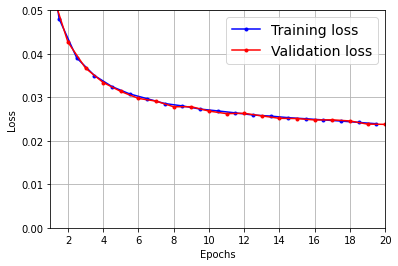

In [ ]:

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

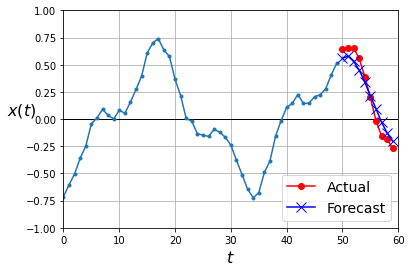

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### Peephole connections <a name="3.1.2"></a>

**In a regular LSTM cell, the gate controllers can look only at the input $\boldsymbol{x}_{(t)}$ and the previous short-term state $\boldsymbol{h}_{(t-1)}$**. It may be a good idea to give them a bit more context by letting them **look at the long-term state as well**. This idea was proposed by Gers and Schmidhuber in 2000. They proposed an LSTM variant with extra connections called ***peephole connections***: the previous long-term state $\boldsymbol{c}_{(t-1)}$
is added as an input to the controllers of the forget gate and the input gate, and the current long-term state $\boldsymbol{c}_{(t)}$ is added as an input to the controller of the output gate. This often improves performance, but not always, and there is no clear pattern for which tasks are better off with or without them: we will have to try it on your task and see if it helps.

In Keras, the LSTM layer is based on the `keras.layers.LSTMCell` cell, which does not support peepholes. The experimental `tf.keras.experimental.PeepholeLSTMCell` does, so we can create a `keras.layers.RNN` layer and pass a `PeepholeLSTMCell` to its constructor.

## GRU cells <a name="3.2"></a>

One popular **variant of the LSTM cell** is the GRU cell. The ***Gated Recurrent Unit (GRU)*** cell was proposed in 2014 in a [paper](https://arxiv.org/abs/1406.1078) that also introduced the Encoder-Decoder network.

![texto alternativo](https://i.ibb.co/mJ92Hjw/GRU-cell-2.png)

The GRU cell is a **simplified version of the LSTM cell**, and it seems to **perform just as well** (which explains its growing popularity). These are the main **simplifications**:

- **Both state vectors are merged into a single vector** $\boldsymbol{h}_{(t)}$.

- **A single gate controller $\boldsymbol{z}_{(t)}$ controls both the forget gate and the input gate**. If the gate controller outputs a 1, the forget gate is open (= 1) and the input gate is closed (1 – 1 = 0). If it outputs a 0, the opposite happens. In other words, whenever a memory must be stored, the location where it will be stored is erased first.

- There is no output gate; the full state vector is output at every time step. However, **there is a new gate controller $\boldsymbol{r}_{(t)}$ that controls which part of the previous state will be shown to the main layer** $(\boldsymbol{g}_{(t)})$.

The next equation summarizes how to compute the cell’s state at each time step for a single instance.

\begin{cases}
\boldsymbol{z}_{(t)} = \sigma(\boldsymbol{W}_{xz}^T\boldsymbol{x}_{(t)}+\boldsymbol{W}_{hz}^T\boldsymbol{h}_{(t-1)}+\boldsymbol{b}_{z})\\\\
\boldsymbol{r}_{(t)} = \sigma(\boldsymbol{W}_{xr}^T\boldsymbol{x}_{(t)}+\boldsymbol{W}_{hr}^T\boldsymbol{h}_{(t-1)}+\boldsymbol{b}_{r})\\\\
\boldsymbol{g}_{(t)} = \text{tanh}(\boldsymbol{W}_{xg}^T\boldsymbol{x}_{(t)}+\boldsymbol{W}_{hg}^T(\boldsymbol{r}_{(t)} \otimes \boldsymbol{h}_{(t-1)})+\boldsymbol{b}_{g})\\\\
\boldsymbol{h}_{(t)} = \boldsymbol{z}_{(t)} \otimes \boldsymbol{h}_{(t-1)} +  (1-\boldsymbol{z}_{(t)}) \otimes  \boldsymbol{g}_{(t)}\\
\end{cases}

### GRU in Keras <a name="3.2.1"></a>

Keras provides a `keras.layers.GRU` layer (based on the `keras.layers.GRUCell` memory cell); using it is just a matter of replacing `SimpleRNN` or `LSTM` with `GRU`.



In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

219/219 [==============================] - 5s 24ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [=============

In [ ]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 8ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785501718521118, 0.0102628068998456]

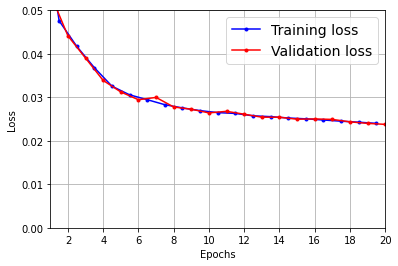

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

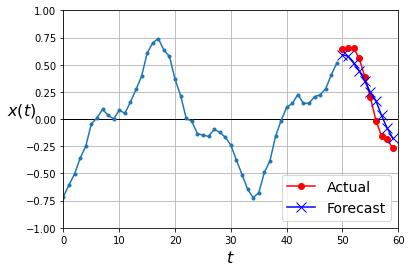

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## 1D convolutional layer to process sequences <a name="3.3"></a>

**LSTM and GRU** cells are one of the main reasons behind the success of RNNs. Yet while they can **tackle much longer sequences than simple RNNs**, they still have a fairly **limited short-term memory**, and they have a hard time **learning long-term patterns in sequences of 100 time steps or more**, such as audio samples, long time series, or long sentences. One way to solve this is to **shorten the input sequences, for example, using 1D convolutional layers**.

In the notebook [Introduction to CNNs](https://nbviewer.jupyter.org/github/victorviro/Deep_learning_python/blob/master/Introduction_to_CNNs.ipynb), we saw that a 2D convolutional layer works by sliding several fairly small kernels (or filters) across an image, producing multiple 2D feature maps (one per kernel). Similarly, a **1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel**. Each kernel will learn to detect a single very short sequential pattern (no longer than the kernel size). If we use 10 kernels, then the layer’s output will be composed of 10 1-dimensional sequences (all of the same length), or equivalently we can view this output as a single 10-dimensional sequence. This means that we can build a neural network composed of a mix of recurrent layers and 1D convolutional layers (or even 1D pooling layers). If we use a 1D convolutional layer with a stride of 1 and "`same`" padding, then the output sequence will have the same length as the input sequence. But if we use "`valid`" padding or a stride greater than 1, then the output sequence will be shorter than the input sequence. 

For example, the **following model** is the same as earlier, except it **starts with a 1D convolutional layer that downsamples the input sequence by a factor of 2**, using a stride of 2. The kernel size is larger than the stride, so all inputs will be used to compute the layer’s output, and therefore the model can learn to preserve the useful information, dropping only the unimportant details. **By shortening the sequences, the convolutional layer may help the `GRU` layers detect longer patterns**. Note that we must also crop off the first three time steps in the targets (since the kernel’s size is 4, the first output of the convolutional layer will be based on the input time steps 0 to 3), and downsample the targets by a factor of 2:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [==

If we evaluate this model, we will find that it is the best model so far. The convolutional layer really helps. In fact, it is actually possible to use only 1D convolutional layers and drop the recurrent layers entirely.

## WaveNet <a name="3.4"></a>

In a 2016 [paper](https://arxiv.org/abs/1609.03499), DeepMind researchers introduced an architecture called ***WaveNet***. They stacked **1D convolutional layers, doubling the dilation rate at every layer**. The first convolutional layer gets a glimpse of just two time steps at a time, while the next one sees four time steps (its receptive field is four time steps long), the next one sees eight time steps, and so on (see Figure 15-11). This way, the **lower layers learn short-term patterns, while the higher layers learn long-term patterns**. Thanks to the doubling dilation rate, the network **can process extremely large sequences very efficiently**.

![texto alternativo](https://i.ibb.co/tBph50J/Wave-Net-architecture.png)

- **Note**: **Dilated/Atrous Convolutions** are a type of convolution that **"inflate" the kernel by inserting holes between the kernel elements**. An additional parameter (dilation rate) indicates how much the kernel is widened. Dilated convolution allows us to **enlarge the field of view of filters to incorporate larger context** without increasing the number of parameters or the amount of computation.

In the WaveNet paper, the authors actually stacked 10 convolutional layers with dilation rates of 1, 2, 4, 8, …, 256, 512, then they stacked another group of 10 identical layers (also with dilation rates 1, 2, 4, 8, …, 256, 512), then again another identical group of 10 layers. They justified this architecture by pointing out that a single stack of 10 convolutional layers with these dilation rates will act like a super-efficient convolutional layer with a kernel of size 1,024 (except way faster, more powerful, and using significantly fewer parameters), which is why they stacked 3 such blocks. They also left-padded the input sequences with a number of zeros equal to the dilation rate before every layer, to preserve the same sequence length throughout the network. 

Here is how to **implement a simplified WaveNet** to tackle the same sequences as earlier:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0668 - last_time_step_mse: 0.0543 - val_loss: 0.0365 - val_last_time_step_mse: 0.0230
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0323 - last_time_step_mse: 0.0193 - val_loss: 0.0294 - val_last_time_step_mse: 0.0166
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0283 - last_time_step_mse: 0.0156 - val_loss: 0.0269 - val_last_time_step_mse: 0.0144
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0261 - last_time_step_mse: 0.0136 - val_loss: 0.0253 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0248 - last_time_step_mse: 0.0124 - val_loss: 0.0245 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0240 - last_time_step_mse: 0.0117 - val_loss: 0.0233 - val_last_time_step_mse: 0.0108
Epoch 7/20
219/219 [=======

This `Sequential` model starts with an explicit input layer (this is simpler than trying to set `input_shape` only on the first layer), then continues with a 1D convolutional layer using "`causal`" padding: this ensures that the convolutional layer does not peek into the future when making predictions (it is equivalent to padding the inputs with the right amount of zeros on the left and using "`valid`" padding). We then add similar pairs of layers using growing dilation rates: 1, 2, 4, 8, and again 1, 2, 4, 8. Finally, we add the output layer: a convolutional layer with 10 filters of size 1 and without any activation function. Thanks to the padding layers, every convolutional layer outputs a sequence of the same length as the input sequences, so the targets we use during training can be the full sequences: no need to crop them or downsample them. The original WaveNet defined in the paper uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences.

WaveNet achieved state-of-the-art performance on various audio tasks (hence the name of the architecture), including text-to-speech tasks, producing incredibly realistic voices across several languages. They also used the model to generate music, one audio sample at a time. This feat is all the more impressive when you realize that a single second of audio can contain tens of thousands of time steps, even LSTMs and GRUs cannot handle such long sequences.

# References <a name="4"></a>

- [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

- https://github.com/ageron/handson-ml2

- [RNNs MIT lecture](https://www.youtube.com/watch?v=SEnXr6v2ifU)

- [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)